<a href="https://colab.research.google.com/github/PedroNatali/Spatio-Temporal-Forecasting-of-Events-Using-Graph-Convolutional-Neural-Networks/blob/main/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Test Code

## Run STGCN

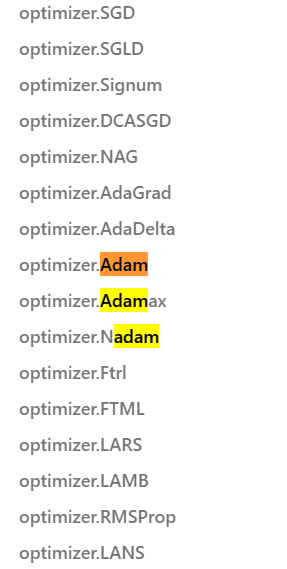

In [ ]:

'''

1)The linear interpolation method is used to fill missing values after data cleaning. In addition, data input are normalized by Z-Score method.

2)Both the graph convolution kernel size K and temporal convolution kernel size Kt are set to 3 in the model
  STGCN(Cheb) with the Chebyshev polynomials approximation, while the K is set to 1 in the model STGCN(1st) with the 1st-order approximation

3)The initial learning rate is 10−3 with a decay rate of 0.7 after every 5 epochs

4)We train our models by minimizing the mean square error using RMSprop for 50 epochs with batch size as 50

5)All the tests use 60 minutes as the historical time window, a.k.a. 12 observed data points (M = 12) are used to forecast traffic conditions
  in the next 15, 30, and 45 minutes (H = 3, 6, 9).

6) OPT -> adam, RMSProp 

'''

import os
import argparse

import mxnet as mx
from mxnet import nd

ctx = mx.gpu(0)

global minMae
minMae = 99

isFinalResult = False

result_list = []

parser = argparse.ArgumentParser()
parser.add_argument('--num_of_vertices', type=int, default=275)
parser.add_argument('--n_his', type=int, default=9)
parser.add_argument('--n_pred', type=int, default=1)
parser.add_argument('--batch_size', type=int, default=50)
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--save', type=int, default=10)
parser.add_argument('--order_of_cheb', type=int, default=1)
parser.add_argument('--kt', type=int, default=1)
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--opt', type=str, default='adam')
parser.add_argument('--keep_prob', type=float, default=1.0)
parser.add_argument('--adj_path', type=str,
                    default='/content/drive/MyDrive/TCC /Sensor Data/SeDATM_W.csv')
parser.add_argument('--time_series_path', type=str,
                    default='/content/drive/MyDrive/TCC /Sensor Data/SeDATM_V.csv')

args, unknown = parser.parse_known_args()
print('Training configs: {}'.format(args))

n_his, n_pred = args.n_his, args.n_pred
order_of_cheb = args.order_of_cheb


adj = weight_matrix(args.adj_path)
L = scaled_laplacian(adj)
cheb_polys = nd.array(cheb_poly_approx(L, order_of_cheb))

# Data Preprocessing
PeMS_dataset = data_gen(args.time_series_path, n_his + n_pred)
print('>> Loading dataset with Mean: {0:.2f}, STD: {1:.2f}'.format(
    PeMS_dataset.mean,
    PeMS_dataset.std))

import shutil

# blocks: settings of channel size in st_conv_blocks / bottleneck design
blocks = [[1, 32, 64], [64, 32, 128]]

logdir = './logdir'
if os.path.exists(logdir):
    shutil.rmtree(logdir)


model_train(blocks, args, PeMS_dataset, cheb_polys, ctx, logdir=logdir)

# file = open("/content/drive/MyDrive/TCC /log.txt", "w")
# file.write("initialiazing...")

# for i in range(33):
#     blocks = [[1, i, 2*i], [2*i, i, 4*i]]
#     try: 
#       model_train(blocks, args, PeMS_dataset, cheb_polys, ctx, logdir=logdir)
#       file.write("\nSucceded with block: " + str(blocks))  
#       print(blocks)
#     except:
#       print(i)

# file.close()


Training configs: Namespace(adj_path='/content/drive/MyDrive/TCC /Sensor Data/SeDATM_W.csv', batch_size=50, epochs=50, keep_prob=1.0, kt=1, lr=0.001, n_his=9, n_pred=1, num_of_vertices=275, opt='adam', order_of_cheb=1, save=10, time_series_path='/content/drive/MyDrive/TCC /Sensor Data/SeDATM_V.csv')

Num of samples: 66
>> Loading dataset with Mean: 0.01, STD: 0.05
step: 0, MAPE: 35683056.0, MAE: 0.05163882300257683, RMSE: 0.055266667157411575
step: 1, MAPE: 16013431.0, MAE: 0.026100577786564827, RMSE: 0.031998611986637115
step: 2, MAPE: 7409060.0, MAE: 0.0134635791182518, RMSE: 0.020694931969046593
step: 8, MAPE: 5580155.0, MAE: 0.011980177834630013, RMSE: 0.020058471709489822
step: 9, MAPE: 2398640.75, MAE: 0.009428132325410843, RMSE: 0.020212380215525627
step: 10, MAPE: 2053564.75, MAE: 0.009389808401465416, RMSE: 0.020631568506360054
step: 13, MAPE: 2213732.0, MAE: 0.009341420605778694, RMSE: 0.020234907045960426
step: 14, MAPE: 2213302.0, MAE: 0.009118733927607536, RMSE: 0.01989030

Tentativas:
(COM n_pred = 1)
*   Iterar com i,j,k de 0 a 32 pegando todos **(não funcionou)**
*   Iterar com i,j,k de 0 a 32 pegando só os pares**(não funcionou)**
*   Iterar com i,j,k de 0 a 64 pegando só os pares **(45 min e não funcionou)**
*   Fixar o 1 e iterar de 0 a 64 pegando só os pares **(não funcionou)**
*   Fixar o 1 e iterar de 0 a 64 **(não funcionou)**
*   Iterar com proporcionalidade j,k sendo k = 2j .. assim só itera uma vez --> Indo até 128 no range **(não funcionou)**
*   Iterar com dois blocos com proporcionalidade **(não funcionou)**
*   Iterar com range 4 (0 a 3) variando i,j,k,l,m,n **(não funcionou)**








## Creating dataframe to STGCN based on pkl archive

In [ ]:
# Checking size of datasets (228 common for PEM and 56 common for SeDATM)


df_W = pd.read_csv('/content/drive/MyDrive/TCC /STGCN/datasets/PeMSD7_W_228.csv', header = None)
df_V = pd.read_csv('/content/drive/MyDrive/TCC /STGCN/datasets/PeMSD7_V_228.csv', header = None)

print(df_W.shape, df_V.shape)

print()

df_w_my = pd.read_csv('/content/drive/MyDrive/TCC /Sensor Data/SeDATM_W_56.csv', header = None)
df_v_my = pd.read_csv('/content/drive/MyDrive/TCC /Sensor Data/SeDATM_V_56.csv', header = None)

print(df_w_my.shape , df_v_my.shape)

(228, 228) (12672, 228)

(56, 56) (27, 56)


In [ ]:
import pandas as pd

df_sensor_distance_matrix = pd.read_pickle('/content/drive/MyDrive/TCC /Sensor Data/df_sensor_distance_matrix.pkl')

df_csv = df_sensor_distance_matrix.to_csv('/content/drive/MyDrive/TCC /Sensor Data/SeDATM_W_56.csv', header= None, index = None)

In [ ]:
df_sensor_matrix = pd.read_csv('/content/drive/MyDrive/TCC /Sensor Data/SeDATM_W_56.csv', header = None)



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55
0,0.000000,0.809615,0.960481,0.551701,0.815139,0.785948,0.800205,0.759421,0.820893,0.519711,0.820316,0.680418,0.847997,0.759316,0.716988,0.911661,0.649278,0.631664,0.819103,0.911512,0.758453,0.812993,0.844859,0.971249,0.619300,0.786918,0.778234,0.959363,0.560219,0.547772,0.576930,0.943693,0.734762,0.625844,0.798399,0.700138,0.855754,0.778989,0.552598,0.791350,0.850488,0.642788,0.664789,0.705780,0.446250,0.428105,0.657788,0.449677,0.838003,0.852790,0.807628,0.819673,0.871517,0.651346,0.684105,0.679391
1,0.809615,0.000000,0.609201,0.522545,0.726389,0.831032,0.753878,0.801770,0.786983,0.795970,0.754401,0.838005,0.896368,0.816750,0.842910,0.674441,0.774188,0.785635,0.782051,0.546123,0.792443,0.655778,0.661386,0.791442,0.728286,0.775681,0.706855,0.645815,0.735622,0.729389,0.669754,0.611524,0.742111,0.789936,0.816964,0.856777,0.948803,0.612129,0.913557,0.818402,0.866352,0.784008,0.694392,0.702907,0.759022,0.804969,0.830577,0.777551,0.887347,0.783694,0.756841,0.935810,0.890754,0.796783,0.868659,0.788945
2,0.960481,0.609201,0.000000,0.821851,0.812920,0.924833,0.881387,0.863312,0.839126,0.951142,0.837701,0.905125,0.936274,0.871170,0.892266,0.865015,0.910260,0.948558,0.867607,0.726375,0.845451,0.765336,0.792681,0.789687,0.896955,0.880100,0.858810,0.815053,0.877435,0.878070,0.820537,0.757939,0.874489,0.958466,0.865584,0.920777,1.023872,0.741099,1.042559,0.875356,0.889416,0.909516,0.846878,0.849807,0.921262,0.964643,0.884064,0.897949,0.926513,0.795468,0.859921,0.991756,0.937025,0.902817,0.929493,0.921850
3,0.551701,0.522545,0.821851,0.000000,0.708983,0.769428,0.715703,0.727892,0.742255,0.561983,0.711458,0.761691,0.840626,0.784584,0.763063,0.850794,0.624910,0.564890,0.740461,0.793131,0.740523,0.687317,0.782357,0.918780,0.585221,0.734425,0.752519,0.885299,0.507717,0.498752,0.530222,0.854661,0.665049,0.584664,0.759921,0.780683,0.866988,0.684277,0.709446,0.748536,0.863728,0.712218,0.620502,0.648299,0.535708,0.564137,0.741569,0.599637,0.825402,0.784306,0.760585,0.889831,0.858520,0.654947,0.801222,0.664784
4,0.815139,0.726389,0.812920,0.708983,0.000000,0.414988,0.657064,0.651020,0.603051,0.769748,0.582254,0.767315,0.793231,0.721493,0.712197,0.798235,0.760727,0.723220,0.655275,0.749786,0.669085,0.660841,0.758511,0.781835,0.694767,0.703668,0.678416,0.856144,0.668980,0.678996,0.703199,0.799748,0.639173,0.721354,0.658385,0.765032,0.864047,0.700879,0.885403,0.659581,0.797074,0.771501,0.733790,0.700173,0.780373,0.803218,0.739561,0.823837,0.771351,0.645503,0.673791,0.868345,0.763368,0.760405,0.810512,0.719836
5,0.785948,0.831032,0.924833,0.769428,0.414988,0.000000,0.817483,0.816546,0.696308,0.729947,0.769780,0.731089,0.858125,0.678842,0.675146,0.863823,0.823924,0.807754,0.780470,0.850000,0.813298,0.773274,0.828722,0.897379,0.773485,0.778148,0.810492,0.968063,0.790314,0.820342,0.796903,0.892289,0.743311,0.790849,0.834368,0.728269,0.879715,0.823363,0.858888,0.835120,0.869924,0.745361,0.779928,0.670682,0.741698,0.774072,0.694905,0.819450,0.848262,0.827699,0.760501,0.857431,0.895682,0.881955,0.789636,0.768460
6,0.800205,0.753878,0.881387,0.715703,0.657064,0.817483,0.000000,0.669505,0.653060,0.711569,0.612822,0.819421,0.846711,0.740927,0.731732,0.702164,0.733607,0.724541,0.724597,0.789136,0.714079,0.741942,0.775251,0.907417,0.727152,0.740671,0.690602,0.856624,0.630451,0.639071,0.690472,0.843288,0.664551,0.753560,0.707000,0.842492,0.881708,0.704789,0.879589,0.680010,0.867466,0.546844,0.694456,0.706113,0.746591,0.778524,0.835667,0.815551,0.825729,0.662050,0.655668,0.895396,0.779792,0.716125,0.817487,0.730786
7,0.759421,0.801770,0.863312,0.727892,0.651020,0.816546,0.669505,0.000000,0.683524,0.795848,0.554475,0.489944,0.566714,0.760549,0.763499,0.851035,0.644640,0.745517,0.644175,0.848958,0.209738,0.744125,0.829334,0.865381,0.717564,0.701733,0.583153,0.903651,0.639614,0.618131,0.659818,0.882671,0.637413,

In [ ]:
import pandas as pd
import csv

df_sensor_dataset_pickled = pd.read_pickle('/content/drive/MyDrive/TCC /Sensor Data/sensor_dataset.pkl')

column_names = ["sensor_signal"]
df_result = pd.DataFrame(columns = ["sensor_signal"])

#concatenates result dataframe with each dataframe with sensor_signal present in the list of lists
for i in range(len(df_sensor_dataset_pickled)):
    df_aux = pd.DataFrame(df_sensor_dataset_pickled[i][2], columns = column_names)
    df_result = pd.concat([df_result, df_aux], axis = 1)

#transform column names from sensor_signal to 0 - len(df)
df_result.columns = range(df_result.shape[1])

#drop first column
df_result = df_result.drop(0, axis = 1)

#transform NA to 0
df_result.fillna(0, inplace=True)
df_result_csv = df_result.to_csv('/content/drive/MyDrive/TCC /Sensor Data/SeDATM_V_56.csv', header = None, index = None)

df_sensor_dataset = pd.read_csv('/content/drive/MyDrive/TCC /Sensor Data/SeDATM_V_56.csv', header = None)
df_sensor_dataset







,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55
0,0.019795,0.090405,0.124842,0.019870,0.078700,0.009927,0.051224,0.073925,0.061048,0.004599,0.021543,0.013472,0.136738,0.000000,0.000000,0.000000,0.090109,0.000000,0.046595,0.112229,0.031090,0.039223,0.120652,0.000000,0.000000,0.027467,0.054587,0.246020,0.031552,0.000000,0.000000,0.020625,0.111160,0.000000,0.080174,0.036996,0.253315,0.000000,0.149775,0.035297,0.194377,0.000000,0.066380,0.048000,0.024027,0.017930,0.055284,0.000000,0.212745,0.000000,0.000000,0.075275,0.160612,0.000000,0.000000,0.000000
1,0.031656,0.000000,0.092876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020138,0.000000,0.269069,0.012503,0.000000,0.067027,0.065535,0.000000,0.001303,0.180563,0.000000,0.025208,0.049478,0.236386,0.000000,0.109849,0.031325,0.158540,0.000000,0.049030,0.015756,0.047761,0.000000,0.079621,0.000000,0.000000,0.000000,0.035785,0.163238,0.041546,0.226674,0.000000,0.055821,0.096414,0.000000,0.001805,0.040529,0.029975,0.000000,0.061541,0.029678,0.000000,0.000000,0.130248,0.000000,0.000000
2,0.048652,0.134457,0.145249,0.047748,0.055902,0.000000,0.000000,0.000000,0.019900,0.047444,0.000000,0.041539,0.000000,0.022376,0.000000,0.000000,0.073692,0.065453,0.000000,0.138359,0.000000,0.015643,0.123553,0.311009,0.061199,0.000000,0.000000,0.077440,0.000000,0.000000,0.019157,0.075602,0.134068,0.000000,0.000000,0.045415,0.000000,0.010577,0.177372,0.073248,0.195773,0.000000,0.051122,0.102107,0.011521,0.032217,0.020320,0.039161,0.210857,0.088762,0.000000,0.000000,0.110901,0.000000,0.000000,0.119014
3,0.038496,0.172694,0.132891,0.075590,0.020431,0.032866,0.000000,0.062382,0.026250,0.039445,0.062598,0.037707,0.258783,0.046765,0.011162,0.000000,0.041357,0.099692,0.000000,0.130601,0.094158,0.000000,0.065830,0.285179,0.040723,0.000000,0.036893,0.000000,0.000000,0.000000,0.000000,0.000000,0.134068,0.102114,0.065041,0.031139,0.000000,0.045390,0.000000,0.046495,0.117861,0.000000,0.074456,0.032817,0.010774,0.024695,0.000000,0.015366,0.169280,0.000000,0.000000,0.087417,0.116334,0.226188,0.022401,0.111505
4,0.013323,0.000000,0.093918,0.079337,0.100438,0.000000,0.092933,0.050678,0.028212,0.000000,0.051032,0.016522,0.000000,0.046203,0.040112,0.000000,0.070969,0.084808,0.000000,0.097459,0.000000,0.033448,0.048406,0.000000,0.049605,0.095027,0.046402,0.237217,0.000000,0.000000,0.014247,0.107486,0.076742,0.028576,0.077571,0.066432,0.270854,0.024029,0.194283,0.000000,0.125855,0.016853,0.060445,0.000000,0.014202,0.027801,0.024383,0.000000,0.224744,0.000000,0.078349,0.062470,0.123673,0.182790,0.000000,0.071374
5,0.026843,0.092902,0.000000,0.065530,0.095141,0.069854,0.000000,0.056824,0.000000,0.017020,0.000000,0.000000,0.000000,0.007830,0.014513,0.172530,0.063980,0.000000,0.000000,0.106622,0.061186,0.011795,0.043272,0.337289,0.067790,0.025123,0.057611,0.000000,0.024521,0.010116,0.050210,0.125916,0.135810,0.036753,0.069288,0.082198,0.000000,0.065879,0.000000,0.000000,0.000000,0.000000,0.026122,0.034519,0.013259,0.008979,0.028228,0.000000,0.272415,0.084884,0.039651,0.030961,0.060391,0.226546,0.000000,0.142027
6,0.028534,0.131479,0.000000,0.055006,0.050399,0.096847,0.078349,0.084647,0.017513,0.008429,0.053259,0.000000,0.276838,0.049585,0.040626,0.138848,0.088825,0.000000,0.000000,0.000000,0.036742,0.046934,0.077949,0.245434,0.097224,0.000000,0.073414,0.000000,0.001181,0.024933,0.046062,0.027323,0.145204,0.000000,0.078784,0.079964,0.248812,0.000000,0.000000,0.039138,0.000000,0.022237,0.043593,0.087862,0.003045,0.006977,0.015441,0.049051,0.257116,0.025190,0.081081,0.070197,0.071161,0.205156,0.052479,0.116233
7,0.000000,0.148852,0.117465,0.069995,0.075466,0.000000,0.078896,0.094207,0.026450,0.005847,0.014213,0.000000,0.276838,0.028553,0.035668,0.175107,0.060475,0.011223,0.053734,0.081153,0.051762,0.041602,0.061138,0.000000,0.000000,0.155749,0.036642,0.000000,0.000000,0.021299,0.005563,0.000000,0.111255,

## Prophet Implementation

### Instalation

In [ ]:
!pip install fbprophet

### Create DataSets

In [ ]:
import pandas as pd
import csv

df_sensor_dataset_pickled = pd.read_pickle('/content/drive/MyDrive/TCC /Sensor Data/sensor_dataset_2.pkl')

column_names = ["sensor_signal"]
df_result = pd.DataFrame(columns = ["sensor_signal"])

#concatenates result dataframe with each dataframe with sensor_signal present in the list of lists
for i in range(len(df_sensor_dataset_pickled)):
    df_aux = pd.DataFrame(df_sensor_dataset_pickled[i][2], columns = column_names)
    df_result = pd.concat([df_result, df_aux], axis =1)

#transform column names from sensor_signal to 0 - len(df)
df_result.columns = range(df_result.shape[1])

#drop first column
df_result = df_result.drop(0, axis = 1)

#treating collection of result
df_collection_columnsBySensor = []
df_collection_renamedColumnToY = []
df_collection_renamedAxisToDs = []
df_collection_resetedIndex = []
df_collection_treated = []
df_collection_reduced = []

for i in range(len(df_result)):
  df_collection_columnsBySensor.append(df_result.filter([i+1])); 
  df_collection_renamedColumnToY.append(df_collection_columnsBySensor[i].rename(columns={i+1:'y'}))
  df_collection_renamedAxisToDs.append(df_collection_renamedColumnToY[i].rename_axis("ds"))
  df_collection_resetedIndex.append(df_collection_renamedAxisToDs[i].reset_index()) 
  df_collection_treated.append(df_collection_resetedIndex[i].fillna(0))
  df_collection_reduced.append(df_collection_treated[i][0:len(df_collection_treated[i])-1])


### Run Prophet

In [ ]:
%%capture
from fbprophet import Prophet

prophetCollection = []
futureCollection = []

for i in range(len(df_collection_reduced)):
  prophetCollection.append(Prophet())
  df_collection_reduced[i]['ds'] = df_collection_reduced[i]['ds'].dt.tz_localize(None)
  prophetCollection[i].fit(df_collection_reduced[i])
  futureCollection.append(prophetCollection[i].make_future_dataframe(periods=1))

forecast = []

for i in range(len(futureCollection)):
  forecast.append(prophetCollection[i].predict(futureCollection[i].tail(1)))

y = []
yhat = []
for i in range(len(forecast)):
  y.append(df_collection_treated[i].tail(1))
  yhat.append(forecast[i][['ds','yhat']])

### Calculate Errors Prophet (MAE, MAPE and RMSE)

In [ ]:
pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import math

target = []
prediction = []
for i in range (len(y)):
  if (y[i][['y']].y.item() == 0):
    continue
  target.append(y[i][['y']].y.item())
  prediction.append(yhat[i][['yhat']].yhat.item())

print(target)
print(prediction) 

MAE = mean_absolute_error(target,prediction)
RMSE = math.sqrt(mean_squared_error(target,prediction))
MAPE = mean_absolute_percentage_error(target,prediction)

print("MAE: " + str(MAE) + "\nRMSE: " + str(RMSE) + "\nMAPE: " + str(MAPE))

[0.052850909531116486, 0.013764835894107819, 0.020177867263555527, -0.009840746410191059, 0.051326122134923935, 0.08655773103237152, 0.016438977792859077, -0.020680423825979233, 0.023155562579631805, 0.0159470085054636, -0.012708890251815319, 0.05994746834039688]
[0.027965803453966463, 0.0010065414807616565, 0.001606632720589285, 0.001859168527809082, 0.0041459333015152105, 0.05934000181687599, 0.004297530448309364, 0.000921954673558569, 0.010645884769805585, 0.00018320796447763882, -0.011506331581577316, 0.07039402265643796]
MAE: 0.017998240433462133
RMSE: 0.021134963007837373
MAPE: 0.6934584983660032


# Execution code 

## Libraries

### Install STGCN setup

In [ ]:
#Instalacao das bibliotecas da mxnet e cudamxnet

!pip install mxnet
!pip install mxboard
!pip install mxnet-cu101
!pip install -U scikit-learn
!pip install sklearn
!pip install delayed

     |████████████████████████████████| 46.9MB 64kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 51kB 4.4MB/s 
     |████████████████████████████████| 356.7MB 45kB/s 
     |████████████████████████████████| 22.3MB 1.4MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 81kB 6.7MB/s 
     |████████████████████████████████| 92kB 13.1MB/s 


In [ ]:
import csv

import numpy as np

from scipy.sparse.linalg import eigs
from sklearn.metrics import mean_absolute_percentage_error
import math

def scaled_laplacian(W):
    '''
    Normalized graph Laplacian

    Parameters
    ----------
    W: np.ndarray, adjacency matrix,
       shape is (num_of_vertices, num_of_vertices)

    Returns
    ----------
    np.ndarray, shape is (num_of_vertices, num_of_vertices)

    '''

    num_of_vertices = W.shape[0]
    d = np.sum(W, axis=1)
    L = np.diag(d) - W
    for i in range(num_of_vertices):
        for j in range(num_of_vertices):
            if (d[i] > 0) and (d[j] > 0):
                L[i, j] = L[i, j] / np.sqrt(d[i] * d[j])
    # lambda_max \approx 2.0, the largest eigenvalues of L.
    lambda_max = eigs(L, k=1, which='LR')[0][0].real
    return 2 * L / lambda_max - np.identity(num_of_vertices)


def cheb_poly_approx(L, order_of_cheb):
    '''
    Chebyshev polynomials approximation

    Parameters
    ----------
    L: np.ndarray, scaled graph Laplacian,
       shape is (num_of_vertices, num_of_vertices)

    Returns
    ----------
    np.ndarray, shape is (num_of_vertices, order_of_cheb * num_of_vertices)

    '''

    if order_of_cheb == 1:
        return np.identity(L.shape[0])

    cheb_polys = [np.identity(L.shape[0]), L]

    for i in range(2, order_of_cheb):
        cheb_polys.append(2 * L * cheb_polys[i - 1] - cheb_polys[i - 2])

    return np.concatenate(cheb_polys, axis=-1)


def first_approx(adj):
    '''
    1st-order approximation

    Parameters
    ----------
    adj: np.ndarray, adjacency matrix,
         shape is (num_of_vertices, num_of_vertices)

    Returns
    ----------
    np.ndarray, shape is (num_of_vertices, num_of_vertices)

    '''
    A = adj + np.identity(adj.shape[0])
    sinvD = np.sqrt(np.diag(np.sum(A, axis=1)).I)
    # refer to Eq.5
    return np.identity(adj.shape[0]) + sinvD * A * sinvD


def weight_matrix(file_path, sigma2=0.1, epsilon=0.5, scaling=True):
    '''
    Load weight matrix

    Parameters
    ----------
    file_path: str, path of adjacency matrix file

    sigma2: float, default 0.1, scalar of matrix adj

    epsilon: float, default 0.5,
             thresholds to control the sparsity of matrix adj

    scaling: bool, default True, whether applies numerical scaling on adj

    Returns
    ----------
    np.ndarray, shape is (num_of_vertices, num_of_vertices)

    '''
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        adj = np.array([list(map(float, i)) for i in reader if i])

    # check whether adj is a 0/1 matrix.
    if set(np.unique(adj)) == {0, 1}:
        print('The input graph is a 0/1 matrix; set "scaling" to False.')
        scaling = False

    if scaling:
        adj = adj / 10
        mask = np.ones_like(adj) - np.identity(adj.shape[0])
        # refer to Eq.10
        exp = np.exp(- adj ** 2 / sigma2)
        return exp * (exp >= epsilon) * mask
    return adj

def z_score(x, mean, std):
  '''
  Z-score normalization

  Parameters
  ----------
  x: np.ndarray

  mean: float

  std: float

  Returns
  ----------
  np.ndarray

  '''

  return (x - mean) / std


def z_inverse(x, mean, std):
    '''
    The inverse of function z_score()

    Parameters
    ----------
    x: np.ndarray

    mean: float

    std: float

    Returns
    ----------
    np.ndarray

    '''
    return x * std + mean


def masked_mape_np(y_true, y_pred, null_val=0):
    '''
    MAPE
    '''
    target = []
    prediction = []
    for i in range (len(y_true[-1][-1][-1])):
      if (y_true[-1][-1][-1][i] == 0):
        continue
      target.append(y_true[-1][-1][-1][i])
      prediction.append(y_pred[-1][-1][-1][i])

    MAPE = mean_absolute_percentage_error(target,prediction)

    return np.mean(MAPE)
    
    # with np.errstate(divide='ignore', invalid='ignore'):
    #     if np.isnan(null_val):
    #         mask = ~np.isnan(y_true)
    #     else:
    #         mask = np.not_equal(y_true, null_val)
    #     mask = mask.astype('float32')
    #     mask /= np.mean(mask)
    #     mape = np.abs(np.divide((y_pred - y_true).astype('float32'), y_true))
    #     mape = np.nan_to_num(mask * mape)
    #     return np.mean(mape) 


def RMSE(y_true, y_pred):
    '''
    Mean squared error
    '''
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


def MAE(y_true, y_pred):
    '''
    Mean absolute error
    '''
    return np.mean(np.abs(y_true - y_pred))

In [ ]:
from mxnet import nd
import mxnet as mx
from mxnet.gluon import nn


class Gconv(nn.Block):
    def __init__(self, order_of_cheb, c_out, **kwargs):
        super(Gconv, self).__init__(**kwargs)
        self.order_of_cheb = order_of_cheb
        with self.name_scope():
            self.theta = nn.Dense(c_out, activation=None,
                                  flatten=False, use_bias=False)

    def forward(self, x, cheb_polys):
        '''
        Parameters
        ----------
        x: nd.array, shape is (batch_size * time_step, num_of_vertices, c_in)

        cheb_polys: nd.array,
                shape is (num_of_vertices, order_of_cheb * num_of_vertices)

        Returns
        ----------
        shape is (batch_size * time_step, num_of_vertices, c_out)

        '''

        _, num_of_vertices, c_in = x.shape

        # (batch_size * c_in, num_of_vertices)
        x_tmp = x.transpose((0, 2, 1)).reshape((-1, num_of_vertices))

        # (batch_size, c_in, order_of_cheb, num_of_vertices)
        x_mul = nd.dot(x_tmp, cheb_polys).reshape((-1,
                                                   c_in,
                                                   self.order_of_cheb,
                                                   num_of_vertices))

        # (batch_size, num_of_vertices, c_in * order_of_cheb)
        x_ker = x_mul.transpose((0, 3, 1, 2)) \
                     .reshape((-1, num_of_vertices, c_in * self.order_of_cheb))

        return self.theta(x_ker)


class Temporal_conv_layer(nn.Block):
    def __init__(self, Kt, c_in, c_out, activation='relu', **kwargs):
        super(Temporal_conv_layer, self).__init__(**kwargs)
        self.Kt = Kt
        self.c_out = c_out
        self.activation = activation
        with self.name_scope():
            self.align = Align_layer(c_in, c_out, None)
            if activation == 'GLU':
                self.conv = nn.Conv2D(2 * c_out, (Kt, 1), activation=None)
            elif activation == 'relu':
                self.conv = nn.Conv2D(c_out, (Kt, 1), activation=None)
            else:
                self.conv = nn.Conv2D(c_out, (Kt, 1), activation=activation)

    def forward(self, x):
        '''
        Parameters
        ----------
        x: nd.array, shape is (batch_size, c_in, time_step, num_of_vertices)

        Returns
        ----------
        shape is (batch_size, c_out, time_step - Kt + 1, num_of_vertices)

        '''

        x_input = self.align(x)[:, :, self.Kt - 1:, :]

        x_conv = self.conv(x)
        if self.activation == 'GLU':
            x_conv = self.conv(x)
            x_conv1, x_conv2 = nd.split(x_conv, axis=1, num_outputs=2)
            return (x_conv1 + x_input) * nd.sigmoid(x_conv2)
        if self.activation == 'relu':
            return nd.relu(x_conv + x_input)
        return x_conv


class decrease_layer(nn.Block):
    def __init__(self, c_out, activation=None, **kwargs):
        super(decrease_layer, self).__init__(**kwargs)
        self.c_out = c_out
        with self.name_scope():
            self.layer = nn.Conv2D(c_out, (1, 1),
                                   activation=activation, use_bias=False)

    def forward(self, x):
        return self.layer(x)


class increase_layer(nn.Block):
    def __init__(self, c_out, activation=None, **kwargs):
        super(increase_layer, self).__init__(**kwargs)
        self.c_out = c_out

    def forward(self, x):
        batch_size, c, T, num_of_vertices = x.shape
        zeros = nd.zeros(shape=(batch_size, self.c_out - c,
                                T, num_of_vertices),
                         ctx=x.context)
        return nd.concat(x, zeros, dim=1)


class Align_layer(nn.Block):
    def __init__(self, c_in, c_out, activation=None, **kwargs):
        super(Align_layer, self).__init__(**kwargs)
        self.c_in, self.c_out = c_in, c_out
        if self.c_in < self.c_out:
            self.layer = increase_layer(c_out, None)
        elif self.c_in > self.c_out:
            self.layer = decrease_layer(c_out, None)

    def forward(self, x):
        if self.c_in == self.c_out:
            return x
        return self.layer(x)


class Spatio_conv_layer(nn.Block):
    def __init__(self, order_of_cheb, c_in, c_out,
                 cheb_polys, **kwargs):
        super(Spatio_conv_layer, self).__init__(**kwargs)
        self.c_out = c_out
        self.cheb_polys = self.params.get_constant('cheb_polys',
                                                   value=cheb_polys)
        with self.name_scope():
            self.align = Align_layer(c_in, c_out, None)
            self.gconv = Gconv(order_of_cheb, c_out)

    def forward(self, x):
        '''
        Parameters
        ----------
        x: nd.array, shape is (batch_size, c_in, time_step, num_of_vertices)

        Returns
        ----------
        shape is (batch_size, c_out, time_step, num_of_vertices)
        '''
        batch_size, c_in, T, num_of_vertices = x.shape
        x_input = self.align(x)

        x_tmp = x.transpose((0, 2, 3, 1)) \
                 .reshape((-1, num_of_vertices, c_in))

        x_gconv = self.gconv(x_tmp, self.cheb_polys.data())

        x_gc = x_gconv.reshape((-1, T, num_of_vertices, self.c_out)) \
                      .transpose((0, 3, 1, 2))

        x_gc = x_gc[:, : self.c_out, :, :]
        return nd.relu(x_gc + x_input)


class St_conv_block(nn.Block):
    def __init__(self, order_of_cheb, Kt, channels, keep_prob,
                 cheb_polys, activation='GLU', **kwargs):
        super(St_conv_block, self).__init__(**kwargs)
        c_si, c_t, c_oo = channels
        self.order_of_cheb = order_of_cheb
        self.Kt = Kt
        self.keep_prob = keep_prob
        self.seq = nn.Sequential()
        self.seq.add(
            Temporal_conv_layer(Kt, c_si, c_t, activation),
            Spatio_conv_layer(order_of_cheb, c_t, c_t, cheb_polys),
            Temporal_conv_layer(Kt, c_t, c_oo),
            nn.LayerNorm(axis=1),
            nn.Dropout(1 - keep_prob)
        )

    def forward(self, x):
        '''
        Parameters
        ----------
        x: nd.array,
           shape is (batch_size, channels[0], time_step, num_of_vertices)

        Returns
        ----------
        shape is (batch_size, channels[-1],
                  time_step - 2(Kt - 1), num_of_vertices)
        '''
        return self.seq(x)


class Output_layer(nn.Block):
    def __init__(self, c_in, T, activation='GLU', **kwargs):
        super(Output_layer, self).__init__(**kwargs)
        self.c_in = c_in
        with self.name_scope():
            self.layer = nn.Sequential()
            self.layer.add(
                Temporal_conv_layer(T, c_in, c_in, activation),
                nn.LayerNorm(axis=1),
                Temporal_conv_layer(1, c_in, c_in, 'sigmoid'),
                nn.Conv2D(1, (1, 1), activation=None)
            )

    def forward(self, x):
        '''
        Parameters
        ----------
        x: nd.array, shape is (batch_size, c_in, time_step, num_of_vertices)

        Returns
        ----------
        shape is (batch_size, 1, 1, num_of_vertices)
        '''
        return self.layer(x)

In [ ]:

class STGCN(nn.Block):
    def __init__(self, n_his, order_of_cheb, Kt, blocks, keep_prob,
                 cheb_polys, **kwargs):
        super(STGCN, self).__init__(**kwargs)
        self.model = nn.Sequential()
        for idx, channels in enumerate(blocks):
            self.model.add(St_conv_block(order_of_cheb,
                                         Kt,
                                         channels,
                                         keep_prob,
                                         cheb_polys))
            n_his -= 2 * (Kt - 1)

        if n_his > 1:
            self.model.add(Output_layer(blocks[-1][-1], n_his))

    def forward(self, x):
        '''
        Parameters
        ----------
        x: mx.ndarray, shape is (batch_size, 1, n_his, num_of_vertices)

        '''
        return self.model(x)

In [ ]:
from mxnet import nd
import mxnet as mx
from mxnet.gluon import nn


class Gconv(nn.HybridBlock):
    def __init__(self, order_of_cheb, c_in, c_out, num_of_vertices, **kwargs):
        super(Gconv, self).__init__(**kwargs)
        self.order_of_cheb = order_of_cheb
        self.c_in = c_in
        self.c_out = c_out
        self.num_of_vertices = num_of_vertices
        with self.name_scope():
            self.theta = nn.Dense(c_out, activation=None, flatten=False)

    def hybrid_forward(self, F, x, cheb_polys):
        '''
        Parameters
        ----------
        x: nd.array, shape is (batch_size * time_step, num_of_vertices, c_in)

        cheb_polys: nd.array,
                shape is (num_of_vertices, order_of_cheb * num_of_vertices)

        Returns
        ----------
        shape is (batch_size * time_step, num_of_vertices, c_out)
        '''

        # (batch_size * c_in, num_of_vertices)
        x_tmp = x.transpose((0, 2, 1)).reshape((-1, self.num_of_vertices))

        # (batch_size, c_in, order_of_cheb, num_of_vertices)
        x_mul = F.dot(x_tmp, cheb_polys).reshape((-1,
                                                 self.c_in,
                                                 self.order_of_cheb,
                                                 self.num_of_vertices))

        # batch_size, num_of_vertices, c_in * order_of_cheb
        x_ker = x_mul.transpose((0, 3, 1, 2)) \
                     .reshape((-1, self.num_of_vertices,
                               self.c_in * self.order_of_cheb))

        x_gconv = self.theta(x_ker)
        return x_gconv


class Temporal_conv_layer(nn.HybridBlock):
    def __init__(self, Kt, c_in, c_out, activation='relu', **kwargs):
        super(Temporal_conv_layer, self).__init__(**kwargs)
        self.Kt = Kt
        self.c_in = c_in
        self.c_out = c_out
        self.activation = activation
        with self.name_scope():
            if c_in > c_out:
                self.res_conv = nn.Conv2D(c_out, kernel_size=(1, 1),
                                          activation=None, use_bias=False)
            if activation == 'GLU':
                self.conv = nn.Conv2D(2 * c_out, (Kt, 1), activation=None)
            elif activation == 'relu':
                self.conv = nn.Conv2D(c_out, (Kt, 1), activation=None)
            else:
                self.conv = nn.Conv2D(c_out, (Kt, 1), activation=activation)

    def hybrid_forward(self, F, x):
        '''
        Parameters
        ----------
        x: nd.array, shape is (batch_size, c_in, time_step, num_of_vertices)

        Returns
        ----------
        shape is (batch_size, c_out, time_step - Kt + 1, num_of_vertices)

        '''

        if self.c_in == self.c_out:
            x_input = x
        elif self.c_in > self.c_out:
            x_input = self.res_conv(x)
        else:
            padding = F.broadcast_axis(
                        F.slice(
                            F.zeros_like(x),
                            begin=(None, None, None, None),
                            end=(None, 1, None, None)
                        ), axis=1, size=self.c_out - self.c_in)
            x_input = F.concat(x, padding, dim=1)

        x_input = F.slice(x_input,
                          begin=(None, None, self.Kt - 1, None),
                          end=(None, None, None, None))

        x_conv = self.conv(x)
        if self.activation == 'GLU':
            x_conv = self.conv(x)
            x_conv1 = F.slice(x_conv,
                              begin=(None, None, None, None),
                              end=(None, self.c_out, None, None))
            x_conv2 = F.slice(x_conv,
                              begin=(None, self.c_out, None, None),
                              end=(None, None, None, None))
            return (x_conv1 + x_input) * F.sigmoid(x_conv2)
        if self.activation == 'relu':
            return F.relu(x_conv + x_input)
        return x_conv


class Spatio_conv_layer(nn.HybridBlock):
    def __init__(self, order_of_cheb, c_in, c_out, num_of_vertices, T,
                 cheb_polys, **kwargs):
        super(Spatio_conv_layer, self).__init__(**kwargs)
        self.order_of_cheb = order_of_cheb
        self.c_in = c_in
        self.c_out = c_out
        self.num_of_vertices = num_of_vertices
        self.T = T
        self.cheb_polys = self.params.get_constant('cheb_polys',
                                                   value=cheb_polys)
        with self.name_scope():
            if c_in > c_out:
                self.res_conv = nn.Conv2D(c_out, kernel_size=(1, 1),
                                          activation=None, use_bias=False)
            self.gconv = Gconv(order_of_cheb, c_in, c_out, num_of_vertices)

    def hybrid_forward(self, F, x, cheb_polys):
        '''
        Parameters
        ----------
        x: nd.array, shape is (batch_size, c_in, time_step, num_of_vertices)

        cheb_polys: nd.array,
                shape is (num_of_vertices, order_of_cheb * num_of_vertices)

        Returns
        ----------
        shape is (batch_size, c_out, time_step, num_of_vertices)
        '''

        if self.c_in == self.c_out:
            x_input = x
        elif self.c_in > self.c_out:
            x_input = self.res_conv(x)
        else:
            padding = F.broadcast_axis(F.zeros_like(x), axis=1,
                                       size=self.c_out - self.c_in)
            x_input = F.concat(x, padding, dim=1)

        x_tmp = x.transpose((0, 2, 3, 1)) \
                 .reshape((-1, self.num_of_vertices, self.c_in))

        x_gconv = self.gconv(x_tmp, cheb_polys)

        x_gc = x_gconv.reshape((-1, self.T, self.num_of_vertices, self.c_out))\
                      .transpose((0, 3, 1, 2))

        x_gc = F.slice(x_gc,
                       begin=(None, None, None, None),
                       end=(None, self.c_out, None, None))
        return F.relu(x_gc + x_input)


class St_conv_block(nn.HybridBlock):
    def __init__(self, order_of_cheb, Kt, channels, num_of_vertices, keep_prob,
                 T, cheb_polys, activation='GLU', **kwargs):
        super(St_conv_block, self).__init__(**kwargs)
        c_si, c_t, c_oo = channels
        self.order_of_cheb = order_of_cheb
        self.Kt = Kt
        self.keep_prob = keep_prob
        self.seq = nn.HybridSequential()
        self.seq.add(
            Temporal_conv_layer(Kt, c_si, c_t, activation),
            Spatio_conv_layer(order_of_cheb, c_t, c_t,
                              num_of_vertices, T - (Kt - 1), cheb_polys),
            Temporal_conv_layer(Kt, c_t, c_oo),
            nn.LayerNorm(axis=1),
            nn.Dropout(1 - keep_prob)
        )

    def hybrid_forward(self, F, x):
        '''
        Parameters
        ----------
        x: nd.array,
           shape is (batch_size, channels[0], time_step, num_of_vertices)

        Returns
        ----------
        shape is (batch_size, channels[-1],
                  time_step - 2(Kt - 1), num_of_vertices)
        '''
        return self.seq(x)


class Output_layer(nn.HybridBlock):
    def __init__(self, c_in, T, num_of_vertices, activation='GLU', **kwargs):
        super(Output_layer, self).__init__(**kwargs)
        self.c_in = c_in
        self.layer = nn.HybridSequential()
        self.layer.add(
            Temporal_conv_layer(T, c_in, c_in, activation),
            nn.LayerNorm(axis=1),
            Temporal_conv_layer(1, c_in, c_in, 'sigmoid'),
            nn.Conv2D(1, (1, 1), activation=None)
        )

    def hybrid_forward(self, F, x):
        '''
        Parameters
        ----------
        x: nd.array, shape is (batch_size, c_in, time_step, num_of_vertices)

        Returns
        ----------
        shape is (batch_size, 1, 1, num_of_vertices)
        '''
        return self.layer(x)

In [ ]:
class STGCN(nn.HybridBlock):
    def __init__(self, n_his, order_of_cheb, Kt, blocks, keep_prob,
                 num_of_vertices, cheb_polys, **kwargs):
        super(STGCN, self).__init__(**kwargs)
        Ko = n_his
        self.model = nn.HybridSequential()
        for idx, channels in enumerate(blocks):
            self.model.add(
                St_conv_block(order_of_cheb=order_of_cheb,
                              Kt=Kt,
                              channels=channels,
                              num_of_vertices=num_of_vertices,
                              keep_prob=keep_prob,
                              T=n_his - 2 * idx * (Kt - 1),
                              cheb_polys=cheb_polys,
                              activation='GLU')
            )
            Ko -= 2 * (Kt - 1)

        if Ko > 1:
            self.model.add(
                Output_layer(c_in=blocks[-1][-1],
                             T=Ko,
                             num_of_vertices=num_of_vertices,
                             activation='GLU')
            )

    def hybrid_forward(self, F, x):
        return self.model(x)

In [ ]:
import time
import os

import numpy as np
import mxnet as mx
from mxnet import nd
from mxnet import gluon
from mxnet import autograd
from mxboard import SummaryWriter


# from model.tester import model_inference

def model_train(blocks, args, dataset, cheb_polys, ctx, logdir='./logdir'):
    '''
    Parameters
    ----------
    blocks: list[list], model structure, e.g. [[1, 32, 64], [64, 32, 128]]

    args: argparse.Namespace

    dataset: Dataset

    cheb_polys: mx.ndarray,
                shape is (num_of_vertices, order_of_cheb * num_of_vertices)

    ctx: mx.context.Context

    logdir: str, path of mxboard logdir

    '''

    num_of_vertices = args.num_of_vertices
    n_his, n_pred = args.n_his, args.n_pred
    order_of_cheb, Kt = args.order_of_cheb, args.kt
    batch_size, epochs = args.batch_size, args.epochs
    opt = args.opt
    keep_prob = args.keep_prob

    # data
    train = dataset['train'].transpose((0, 3, 1, 2))
    val = dataset['val'].transpose((0, 3, 1, 2))
    test = dataset['test'].transpose((0, 3, 1, 2))

    train_x, train_y = train[:, :, : n_his, :], train[:, :, n_his:, :]
    val_x, val_y = val[:, :, : n_his, :], val[:, :, n_his:, :]
    test_x, test_y = test[:, :, : n_his, :], test[:, :, n_his:, :]

    #print(train_x.shape, train_y.shape, val_x.shape,
    #      val_y.shape, test_x.shape, test_y.shape)

    train_loader = gluon.data.DataLoader(
        gluon.data.ArrayDataset(nd.array(train_x), nd.array(train_y)),
        batch_size=batch_size,
        shuffle=False
    )
    val_loader = gluon.data.DataLoader(
        gluon.data.ArrayDataset(nd.array(val_x), nd.array(val_y)),
        batch_size=batch_size,
        shuffle=False
    )
    test_loader = gluon.data.DataLoader(
        gluon.data.ArrayDataset(nd.array(test_x), nd.array(test_y)),
        batch_size=batch_size,
        shuffle=False
    )

    ground_truth = (np.concatenate([y.asnumpy() for x, y in test_loader],
                                   axis=0) *
                    dataset.std +
                    dataset.mean)

    # model
    model = STGCN(n_his=n_his,
                               order_of_cheb=order_of_cheb,
                               Kt=Kt,
                               blocks=blocks,
                               keep_prob=keep_prob,
                               num_of_vertices=num_of_vertices,
                               cheb_polys=cheb_polys)
    model.initialize(ctx=ctx, init=mx.init.Xavier())
    model.hybridize()

    # loss function
    loss = gluon.loss.L2Loss()

    # trainer
    trainer = gluon.Trainer(model.collect_params(), args.opt)
    trainer.set_learning_rate(args.lr)

    if not os.path.exists('params'):
        os.mkdir('params')

    sw = SummaryWriter(logdir=logdir, flush_secs=5)
    train_step = 0
    val_step = 0

    for epoch in range(epochs):
        start_time = time.time()
        for x, y in train_loader:
            tmp = nd.concat(x, y, dim=2)
            for pred_idx in range(n_pred):
                end_idx = pred_idx + n_his
                x_ = tmp[:, :, pred_idx: end_idx, :]
                y_ = tmp[:, :, end_idx: end_idx + 1, :]
                with autograd.record():
                    l = loss(model(x_.as_in_context(ctx)),
                             y_.as_in_context(ctx))
                l.backward()
                sw.add_scalar(tag='training_loss',
                              value=l.mean().asscalar(),
                              global_step=train_step)
                trainer.step(x.shape[0])
                train_step += 1

        val_loss_list = []
        for x, y in val_loader:
            pred = predict_batch(model, ctx, x, n_his, n_pred)
            val_loss_list.append(loss(pred, y).mean().asscalar())
        sw.add_scalar(tag='val_loss',
                      value=sum(val_loss_list) / len(val_loss_list),
                      global_step=val_step)

        evaluate(model, ctx, ground_truth, test_loader, n_his, n_pred,
                 dataset.mean, dataset.std, sw, val_step)
        val_step += 1

        if (epoch + 1) % args.save == 0:
            model.save_parameters('params/{}.params'.format(epoch + 1))

    sw.close()


def predict_batch(model, ctx, x, n_his, n_pred):
    '''
    Parameters
    ----------
    x: mx.ndarray, shape is (batch_size, 1, n_his, num_of_vertices)

    Returns
    ----------
    mx.ndarray, shape is (batch_size, 1, n_pred, num_of_vertices)
    '''
    predicts = []
    for pred_idx in range(n_pred):
        #x_input = nd.concat(x, *predicts, dim=2)[:, :, - n_pred:, :]
        x_input = nd.concat(x, *predicts, dim=2)[:, :, - n_his:, :]
        predicts.append(model(x_input.as_in_context(ctx))
                        .as_in_context(mx.cpu()))
    return nd.concat(*predicts, dim=2)


def predict(model, ctx, data_loader, n_his, n_pred):
    '''
    predict n_pred time steps

    Returns
    ----------
    mx.ndarray

    '''

    predictions = []
    for x, _ in data_loader:
        predictions.append(predict_batch(model, ctx, x, n_his, n_pred))
    predictions = nd.concat(*predictions, dim=0)
    return predictions


def evaluate(model, ctx, ground_truth, test_loader, n_his,
             n_pred, mean, std, sw, step):
    '''
    evaluate model on testing set

    Parameters
    ----------
    ground_truth: np.ndarray,
                  shape is (num_of_samples, 1, n_pred, num_of_vertices)

    test_loader: gluon.data.DataLoader, contains x and y

    n_pred: int

    mean: int

    std: int

    sw: mxboard.SummaryWriter

    step: int

    '''

    predictions = predict(model, ctx, test_loader, n_his, n_pred).asnumpy()
    pred = z_inverse(predictions, mean, std)

    mape = masked_mape_np(ground_truth, pred, 0)
    mae = MAE(ground_truth, pred)
    rmse = RMSE(ground_truth, pred)

    sw.add_scalar(tag='MAPE', value=mape, global_step=step)
    sw.add_scalar(tag='MAE', value=mae, global_step=step)
    sw.add_scalar(tag='RMSE', value=rmse, global_step=step)

    global minMae
    if (mae < minMae):
      minMae = mae
      print('step: {}, MAPE: {}, MAE: {}, RMSE: {}'.format(step, mape, mae, rmse))
      #result_list.append([step,minMae, numOfVertices, nHis, nPred, batchSize, epochs, save, orderOfCheb, kt, lr, opt, keep_prob, isFinalResult])

In [ ]:
import csv

import numpy as np


class Dataset(object):
    def __init__(self, data, stats):
        self.__data = data
        self.mean = stats['mean']
        self.std = stats['std']

    def __getitem__(self, key):
        return self.__data[key]

    def get_stats(self):
        return {'mean': self.mean, 'std': self.std}

    def z_inverse(self, type_):
        return self.__data[type_] * self.std + self.mean


def seq_gen(data_seq, n_frame):
    '''
    Generate data in the form of standard sequence unit.

    Parameters
    ----------
    data_seq: np.ndarray, time-series, shape is (length, num_of_vertices)


    n_frame: int, n_his + n_pred

    Returns
    ----------
    np.ndarray, shape is (length - n_frame + 1, n_frame, num_of_vertices, 1)

    '''
    
    data = np.zeros(shape=( data_seq.shape[0] - n_frame + 1, n_frame, data_seq.shape[1], 1))
    for i in range(data_seq.shape[0] - n_frame + 1):
        data[i, :, :, 0] = data_seq[i: i + n_frame, :]
    return data


def data_gen(file_path, n_frame=24):
    '''
    Source file load and dataset generation.

    Parameters
    ----------
    file_path: str, path of time series data

    n_frame: int, n_his + n_pred

    Returns
    ----------
    Dataset, dataset that contains training, validation and test with stats.

    '''

    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        data_seq = np.array([list(map(float, i)) for i in reader if i])

    num_of_samples = data_seq.shape[0] #27
    print("\nNum of samples: " + str(num_of_samples))
    
    #0:num_of_samples - 1
    #-1:

    
    seq_train = seq_gen(data_seq[0: 56], n_frame) #length data_seq[0: num_of_samples - 1] = (26, 6) where n_frame = n_his + n_pred
    seq_val = seq_train
    seq_test = seq_gen(data_seq[-10:], n_frame) #length data_seq[-1:] = (1, 6) where n_frame = n_his + n_pred

    #removed Code

    # splitting_line1 = int(num_of_samples * 0.6)
    # splitting_line2 = int(num_of_samples * 0.8)

    #seq_train = seq_gen(data_seq[: splitting_line1], n_frame)
    #seq_val = seq_gen(data_seq[splitting_line1: splitting_line2], n_frame)
    #seq_test = seq_gen(data_seq[splitting_line2:], n_frame)

    mean = np.mean(seq_train)
    std = np.std(seq_train)
    x_stats = {'mean': mean, 'std': std}

    x_train = z_score(seq_train, mean, std)
    x_val = z_score(seq_val, mean, std)
    x_test = z_score(seq_test, mean, std)

    x_data = {'train': x_train, 'val': x_val, 'test': x_test}
    dataset = Dataset(x_data, x_stats)
    return dataset

### Create DataSets

In [ ]:
import pandas as pd
import csv

def createDatasetsBasedOnPkl(weightMatrixInput, weightMatrixOutput, valueMatrixInput, valueMatrixOutput, valueArgMatrixOutput):
  df_sensor_distance_matrix = pd.read_pickle(weightMatrixInput)
  print(df_sensor_distance_matrix.shape)
  df_csv = df_sensor_distance_matrix.to_csv(weightMatrixOutput, header= None, index = None)

  df_sensor_dataset_pickled = pd.read_pickle(valueMatrixInput)

  column_names = ["sensor_signal"]
  df_result = pd.DataFrame(columns = ["sensor_signal"])

  #concatenates result dataframe with each dataframe with sensor_signal present in the list of lists
  for i in range(len(df_sensor_dataset_pickled)):
      df_aux = pd.DataFrame(df_sensor_dataset_pickled[i][2], columns = column_names)
      df_result = pd.concat([df_result, df_aux], axis = 1)

  #transform column names from sensor_signal to 0 - len(df)
  df_result.columns = range(df_result.shape[1])

  #drop first column
  df_result = df_result.drop(0, axis = 1)

  #transform NA to 0
  df_result.fillna(0, inplace=True)
  df_result_csv = df_result.to_csv(valueMatrixOutput, header = None, index = None)
  print(df_result.shape)

  #create testArg matrix
  df_result.drop(df_result.tail(1).index,inplace=True)
  df_csv = df_result.to_csv(valueArgMatrixOutput, header = None, index = None)

### Prophet in Function


In [ ]:
!pip install -U scikit-learn
file = open("/content/drive/MyDrive/TCC /prophetlog.txt", "w")

orig_stdout = sys.stdout
sys.stdout = file

import pandas as pd
import csv

from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import math


def runProphet (datasetUrlPkl): 
  df_sensor_dataset_pickled = pd.read_pickle(datasetUrlPkl)

  column_names = ["sensor_signal"]
  df_result = pd.DataFrame(columns = ["sensor_signal"])

  #concatenates result dataframe with each dataframe with sensor_signal present in the list of lists
  for i in range(len(df_sensor_dataset_pickled)):
      df_aux = pd.DataFrame(df_sensor_dataset_pickled[i][2], columns = column_names)
      df_result = pd.concat([df_result, df_aux], axis =1)

  #transform column names from sensor_signal to 0 - len(df)
  df_result.columns = range(df_result.shape[1])

  #drop first column
  df_result = df_result.drop(0, axis = 1)

  #treating collection of result
  df_collection_columnsBySensor = []
  df_collection_renamedColumnToY = []
  df_collection_renamedAxisToDs = []
  df_collection_resetedIndex = []
  df_collection_treated = []
  df_collection_reduced = []

  for i in range(len(df_result)):
    df_collection_columnsBySensor.append(df_result.filter([i+1])); 
    df_collection_renamedColumnToY.append(df_collection_columnsBySensor[i].rename(columns={i+1:'y'}))
    df_collection_renamedAxisToDs.append(df_collection_renamedColumnToY[i].rename_axis("ds"))
    df_collection_resetedIndex.append(df_collection_renamedAxisToDs[i].reset_index()) 
    df_collection_treated.append(df_collection_resetedIndex[i].fillna(0))
    df_collection_reduced.append(df_collection_treated[i][0:len(df_collection_treated[i])-1])

  prophetCollection = []
  futureCollection = []

  for i in range(len(df_collection_reduced)):
    prophetCollection.append(Prophet())
    df_collection_reduced[i]['ds'] = df_collection_reduced[i]['ds'].dt.tz_localize(None)
    prophetCollection[i].fit(df_collection_reduced[i])
    futureCollection.append(prophetCollection[i].make_future_dataframe(periods=1))

  forecast = []

  for i in range(len(futureCollection)):
    forecast.append(prophetCollection[i].predict(futureCollection[i].tail(1)))

  y = []
  yhat = []
  for i in range(len(forecast)):
    y.append(df_collection_treated[i].tail(1))
    yhat.append(forecast[i][['ds','yhat']])

  target = []
  prediction = []
  for i in range (len(y)):
    if (y[i][['y']].y.item() == 0):
      continue
    target.append(y[i][['y']].y.item())
    prediction.append(yhat[i][['yhat']].yhat.item())
    
  sys.stdout = orig_stdout
  file.close()

  print(target)
  print(prediction) 

  MAE = mean_absolute_error(target,prediction)
  RMSE = math.sqrt(mean_squared_error(target,prediction))
  MAPE = mean_absolute_percentage_error(target,prediction)

  print("MAE: " + str(MAE) + "\nRMSE: " + str(RMSE) + "\nMAPE: " + str(MAPE))


### STGCN in Function

In [ ]:
!pip install mxnet
!pip install mxboard
!pip install mxnet-cu101
!pip install -U scikit-learn
!pip install sklearn
!pip install delayed

import os
import argparse
import mxnet as mx
from mxnet import nd

def runStgcn(numOfVertices, nHis, nPred, batchSize, epochs, save, orderOfCheb, kt, lr, opt, keep_prob, weightMatrix, valueMatrix): 
  ctx = mx.gpu(0)

  parser = argparse.ArgumentParser()
  parser.add_argument('--num_of_vertices', type=int, default=numOfVertices)
  parser.add_argument('--n_his', type=int, default=nHis)
  parser.add_argument('--n_pred', type=int, default=nPred)
  parser.add_argument('--batch_size', type=int, default=batchSize)
  parser.add_argument('--epochs', type=int, default=epochs)
  parser.add_argument('--save', type=int, default=save)
  parser.add_argument('--order_of_cheb', type=int, default=orderOfCheb)
  parser.add_argument('--kt', type=int, default=kt)
  parser.add_argument('--lr', type=float, default=lr)
  parser.add_argument('--opt', type=str, default=opt)
  parser.add_argument('--keep_prob', type=float, default=keep_prob)
  parser.add_argument('--adj_path', type=str, default= weightMatrix)
  parser.add_argument('--time_series_path', type=str, default = valueMatrix)

  args, unknown = parser.parse_known_args()
  print('Training configs: {}'.format(args))

  n_his, n_pred = args.n_his, args.n_pred
  order_of_cheb = args.order_of_cheb


  adj = weight_matrix(args.adj_path)
  L = scaled_laplacian(adj)
  cheb_polys = nd.array(cheb_poly_approx(L, order_of_cheb))

  # Data Preprocessing
  PeMS_dataset = data_gen(args.time_series_path, n_his + n_pred)
  print('>> Loading dataset with Mean: {0:.2f}, STD: {1:.2f}'.format(
      PeMS_dataset.mean,
      PeMS_dataset.std))

  import shutil

  # blocks: settings of channel size in st_conv_blocks / bottleneck design
  blocks = [[1, 32, 64], [64, 32, 128]]

  logdir = './logdir'
  if os.path.exists(logdir):
      shutil.rmtree(logdir)


  model_train(blocks, args, PeMS_dataset, cheb_polys, ctx, logdir=logdir)

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


## Execute 

### Only STGCN with parameters optimization


In [ ]:
import sys
import pandas as pd

#Create matrixes and fileOutput
weightMatrixInput = '/content/drive/MyDrive/TCC /Sensor Data/df_sensor_distance_matrix_2.pkl'
weightMatrixOutput = '/content/drive/MyDrive/TCC /Sensor Data/SeDATM_W.csv'

valueMatrixInput = '/content/drive/MyDrive/TCC /Sensor Data/sensor_dataset_2.pkl'
valueMatrixOutput = '/content/drive/MyDrive/TCC /Sensor Data/SeDATM_V.csv'
valueArgMatrixOutput = '/content/drive/MyDrive/TCC /Sensor Data/SeDATM_V_ARG.csv'

file = open("/content/drive/MyDrive/TCC /ArgumentTestLog.txt", "w")

#define constants
numberOfIterations = 3

#define output
orig_stdout = sys.stdout
sys.stdout = file

result_list = []

for x in range(numberOfIterations):
  
  #defined global variables that are used in STGCN
  global minMae
  minMae = 99

  isFinalResult = False

  file.write("initialiazing search for best arguments...")
  #run all iterations
  for nHis in [3,6,9]: 
    for batchSize in [1,5,10,20,50,100]:
        numOfVertices = 275
        nHis = nHis
        nPred = 1
        batchSize = batchSize
        epochs = 50
        save = 10
        orderOfCheb = 1
        kt = 1
        lr = 1e-3
        opt = 'adam'
        keep_prob = 1.0

        try: 
          print('\nRunning STGCN... ')
          runStgcn(numOfVertices, nHis, nPred, batchSize, epochs, save, orderOfCheb, kt, lr, opt, keep_prob, weightMatrixOutput, valueArgMatrixOutput)
        except:
          print('\nFailed with following arguments of nHis, batch and learning rate in sequence: ' + str(nHis) + '  ' + str(batchSize) + '  ' + str(lr)) 

  #define dataSet with all results.
  result_df = pd.DataFrame(result_list,  columns = ["step", "mae", "numOfVertices", "nHis", "nPred", "batchSize", "epochs", "save", "orderOfCheb", "kt", "lr", "opt", "keep_prob", "isFinalResult"])

  print(result_df)
  # Started running best one
  minMae = 99

  isFinalResult = True

  numOfVertices = result_df.iloc[-1]['numOfVertices']
  nHis = result_df.iloc[-1]['nHis']
  nPred = result_df.iloc[-1]['nPred']
  batchSize =  result_df.iloc[-1]['batchSize']
  epochs = result_df.iloc[-1]['epochs']
  save = result_df.iloc[-1]['save']
  orderOfCheb = result_df.iloc[-1]['orderOfCheb']
  kt = result_df.iloc[-1]['kt']
  lr = result_df.iloc[-1]['lr']
  opt = result_df.iloc[-1]['opt']
  keep_prob = result_df.iloc[-1]['keep_prob']

  print("\nRunning best configuration")
  try:
    runStgcn(numOfVertices, nHis, nPred, batchSize, epochs, save, orderOfCheb, kt, lr, opt, keep_prob, weightMatrixOutput, valueMatrixOutput)
  except: 
    print('\nFailed running best configuration')
 
result_df = pd.DataFrame(result_list,  columns = ["step", "mae", "numOfVertices", "nHis", "nPred", "batchSize", "epochs", "save", "orderOfCheb", "kt", "lr", "opt", "keep_prob", "isFinalResult"])
result_df.to_csv('/content/drive/MyDrive/TCC /resultFinalSheet.csv')

sys.stdout = orig_stdout
file.close()



### Run all without STGCN parameters optimization

In [ ]:
weightMatrixInput = '/content/drive/MyDrive/TCC /Sensor Data/df_sensor_distance_matrix_2.pkl'
weightMatrixOutput = '/content/drive/MyDrive/TCC /Sensor Data/SeDATM_W.csv'

valueMatrixInput = '/content/drive/MyDrive/TCC /Sensor Data/sensor_dataset_2.pkl'
valueMatrixOutput = '/content/drive/MyDrive/TCC /Sensor Data/SeDATM_V.csv'
valueArgMatrixOutput = '/content/drive/MyDrive/TCC /Sensor Data/SeDATM_V_ARG.csv'

print('Creating Datasets...')
createDatasetsBasedOnPkl(weightMatrixInput, weightMatrixOutput, valueMatrixInput, valueMatrixOutput, valueArgMatrixOutput)

#STGCN start

  global minMae
  minMae = 99
  result_list = []
  isFinalResult = True

  numOfVertices = 275
  nHis = 6
  nPred = 1
  batchSize = 50
  epochs = 50
  save = 10
  orderOfCheb = 1
  kt = 1
  lr = 1e-1
  opt = 'adam'
  keep_prob = 1.0


  print('\nRunning STGCN... ')
  runStgcn(numOfVertices, nHis, nPred, batchSize, epochs, save, orderOfCheb, kt, lr, opt, keep_prob, weightMatrixOutput, valueMatrixOutput)

#STGCN end

print('\nRunning Prophet...')
runProphet(valueMatrixInput)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-